# Imports and Setup

In [1]:
import os
if not os.path.exists('steps'):
    os.mkdir('steps')

In [2]:
!pip install ipywidgets --user
!pip install --upgrade jupyter_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 1.3 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: jupyter_client
    Found existing installation: jupyter_client 7.4.9
    Uninstalling jupyter_client-7.4.9:
      Successfully uninstalled jupyter_client-7.4.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.2.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.


In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from scipy import ndimage
import copy
import random
import time
import pickle

torch.set_printoptions(precision=3)
cuda = True if torch.cuda.is_available() else False

In [4]:
def normalize(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    trans = np.transpose(npimg, (1,2,0))
    return np.squeeze(trans)

In [5]:
def imshow(img):
    temp = normalize(img)
    plt.imshow(temp, vmin=0, vmax=1, cmap='Greys_r')
    plt.show()

# Data Entry and Processing

In [6]:
# Transform image to tensor and normalize features from [0,255] to [0,1]
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize((0.5,),(0.5,)),
                                ])

In [7]:
# Using MNIST
traindata = datasets.MNIST('/data', download=True, train=True, transform=transform)
testdata = datasets.MNIST('/data', download=True, train=False, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 37590243.29it/s]


Extracting /data/MNIST/raw/train-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1067773.44it/s]

Extracting /data/MNIST/raw/train-labels-idx1-ubyte.gz to /data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8221791.41it/s]


Extracting /data/MNIST/raw/t10k-images-idx3-ubyte.gz to /data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3560846.50it/s]

Extracting /data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /data/MNIST/raw



In [8]:
# Loaders that give 64 example batches
all_data_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)
all_data_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64, shuffle=True)

In [9]:
# Test dataloader with 3's only
threes_index = []
nonthrees_index = []
for i in range(0, len(testdata)):
    if testdata[i][1] == 3:
        threes_index.append(i)
    else:
        nonthrees_index.append(i)
three_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(threes_index))
nonthree_test_loader = torch.utils.data.DataLoader(testdata, batch_size=64,
              sampler = torch.utils.data.SubsetRandomSampler(nonthrees_index))

In [10]:
# Train dataloaders with limited 3s
nonthrees_index = []
threes_index = []
count = 0
for i in range(0, len(traindata)):
    if traindata[i][1] != 3:
        nonthrees_index.append(i)
        threes_index.append(i)
    if traindata[i][1] == 3 and count < 100:
        count += 1
        threes_index.append(i)
nonthree_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(nonthrees_index))
three_train_loader = torch.utils.data.DataLoader(traindata, batch_size=64,
                     sampler = torch.utils.data.SubsetRandomSampler(threes_index))

In [11]:
# Unlearning dataset with all "3" labels randomly assigned
unlearningdata = copy.deepcopy(traindata)
unlearninglabels = list(range(10))
unlearninglabels.remove(3)
for i in range(len(unlearningdata)):
    if unlearningdata.targets[i] == 3:
        unlearningdata.targets[i] = random.choice(unlearninglabels)
unlearning_train_loader = torch.utils.data.DataLoader(unlearningdata, batch_size=64, shuffle=True)

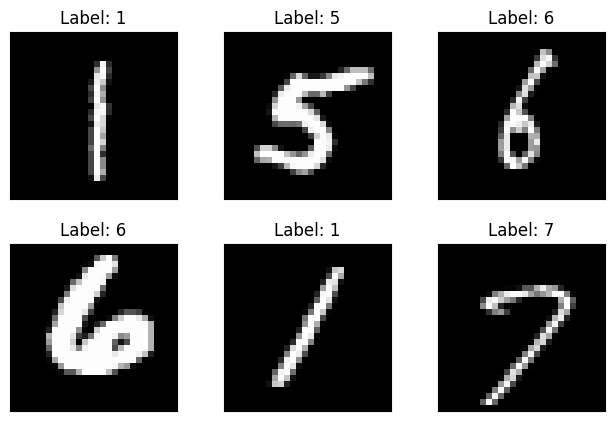

In [12]:
examples = enumerate(unlearning_train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

# Model

In [13]:
class SimpleModel(nn.Module):
    def __init__(self, in_size, out_size, h_size=100):
        super().__init__()
        
        self.in_size = in_size
        self.out_size = out_size
        self.h_size = h_size
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_size, h_size, 3, 2, padding=1),
            nn.ReLU(.1),
            nn.Conv2d(h_size, h_size, 3, 2, padding=1),
            nn.ReLU(.1),
            nn.AdaptiveMaxPool2d((2,2)),
            nn.Flatten(1),
            nn.Linear(4 * h_size, out_size)
        )
        
        nn.init.xavier_normal_(self.layers[0].weight)
        nn.init.zeros_(self.layers[0].bias)
        nn.init.xavier_normal_(self.layers[2].weight)
        nn.init.zeros_(self.layers[2].bias)
        nn.init.xavier_normal_(self.layers[6].weight)
        nn.init.zeros_(self.layers[6].bias)
        
    def forward(self, x):
        return self.layers(x)

In [14]:
# Hyperparameters
batch_size_train = 64
batch_size_test = 64
log_interval = 16
num_classes = 10
torch.backends.cudnn.enabled = True
criterion = F.cross_entropy

In [15]:
# Training method
def train(model, epoch, loader, returnable=False):
    model.train()
    if returnable:
        thracc = []
        nacc = []
        batches = []
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        steps = []
        if 3 in target:
            before = {}
            for param_tensor in model.state_dict():
                if "weight" in param_tensor or "bias" in param_tensor:
                     before[param_tensor] = model.state_dict()[param_tensor].clone()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if 3 in target:
            batches.append(batch_idx)
            after = {}
            for param_tensor in model.state_dict():
                if "weight" in param_tensor or "bias" in param_tensor:
                    after[param_tensor] = model.state_dict()[param_tensor].clone()
            step = {}
            for key in before:
                step[key] = after[key] - before[key]
                f = open(f"steps/e{epoch}b{batches[-1]:04}.pkl", "wb")
                pickle.dump(step, f)
                f.close()
        if batch_idx % log_interval == 0:
            print("\rEpoch: {} [{:6d}]\tLoss: {:.6f}".format(
              epoch, batch_idx*len(data),  loss.item()), end="")
        if returnable and batch_idx % 10 == 0:
            thracc.append(test(model, three_test_loader, dname="Threes only", printable=False))
            if batch_idx % 10 == 0:
                nacc.append(test(model, nonthree_test_loader, dname="nonthree only", printable=False))
            model.train()
    if returnable:
        return thracc, nacc, batches, steps

In [16]:
# Testing method
def test(model, loader, dname="Test set", printable=True):
    model.eval()
    test_loss = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            total += target.size()[0]
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(loader.dataset)
    if printable:
        print('{}: Mean loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            dname, test_loss, correct, total, 
            100. * correct / total
            ))
    return 1. * correct / total

# Original Training

In [17]:
trainingepochs = 4
forgetfulepochs = 4
naive_accuracy_three = []
naive_accuracy_nonthree = []

In [18]:
# load resnet 18 and change to fit problem dimensionality
resnet = SimpleModel(1, num_classes)
#resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
#resnet.fc = nn.Sequential(nn.Linear(512, num_classes))
optimizer = optim.Adam(resnet.parameters())

In [19]:
# Train new model for 5 epochs
steps = []
for epoch in range(1, trainingepochs+1):
    starttime = time.process_time()
    # train(resnet, epoch, all_data_train_loader, returnable=False)
    thracc, nacc, three_batches, three_steps = train(resnet, epoch, three_train_loader, returnable=True)
    naive_accuracy_three += thracc
    naive_accuracy_nonthree += nacc
    steps = steps + three_steps
    print(f"{three_batches} batches effected")
    test(resnet, all_data_test_loader, dname="All data")
    test(resnet, three_test_loader, dname="Threes  ")
    test(resnet, nonthree_test_loader, dname="Nonthree")
    print(f"Time taken: {time.process_time() - starttime}")
    path = F"selective_trained_e{epoch}.pt"
    torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)
    path = F"selective_trained_accuracy_three_e{epoch}.txt"
    with open(path, 'w') as f:
        for data in naive_accuracy_three:
            f.write(f"{data},")
    path = F"selective_trained_accuracy_nonthree_e{epoch}.txt"
    with open(path, 'w') as f:
        for data in naive_accuracy_nonthree:
            f.write(f"{data},")

Epoch: 1 [ 53248]	Loss: 0.036561[44, 54, 69, 87, 91, 97, 100, 104, 119, 127, 129, 130, 133, 149, 163, 168, 176, 177, 179, 180, 193, 200, 203, 208, 214, 221, 226, 231, 233, 235, 241, 262, 270, 292, 298, 300, 302, 305, 307, 320, 321, 351, 358, 360, 367, 370, 373, 376, 393, 401, 404, 408, 415, 427, 441, 450, 462, 463, 465, 514, 523, 526, 548, 557, 559, 570, 585, 586, 596, 601, 605, 612, 614, 615, 617, 629, 674, 682, 683, 690, 704, 708, 715, 732, 751, 755, 777, 780, 785, 786, 816, 826, 829, 836, 843] batches effected
All data: Mean loss: 0.0043, Accuracy: 9111/10000 (91%)
Threes  : Mean loss: 0.0029, Accuracy: 409/1010 (40%)
Nonthree: Mean loss: 0.0014, Accuracy: 8702/8990 (97%)
Time taken: 761.349099848
Epoch: 2 [ 53248]	Loss: 0.076357[11, 18, 33, 36, 47, 50, 57, 58, 62, 67, 77, 84, 94, 120, 124, 134, 137, 140, 143, 155, 178, 194, 196, 199, 228, 235, 248, 254, 271, 285, 291, 297, 326, 328, 339, 345, 368, 389, 398, 416, 423, 450, 454, 457, 462, 463, 465, 473, 479, 485, 488, 493, 499, 507, 

In [20]:
path = F"selective_trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [21]:
path = F"selective_trained_accuracy_three.txt"
with open(path, 'w') as f:
    for data in naive_accuracy_three:
        f.write(f"{data},")

In [22]:
path = F"selective_trained_accuracy_nonthree.txt"
with open(path, 'w') as f:
    for data in naive_accuracy_nonthree:
        f.write(f"{data},")

In [23]:
path = F"selective_trained.pt"
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [24]:
for i in range(1, trainingepochs+1):
    for j in range(1600):
        path = f"steps/e{i}b{j:04}.pkl"
        try:
#             print("before")
            f = open(path, "rb")
            steps = pickle.load(f)
            f.close()
            print(f"\rLoading steps/e{i}b{j:04}.pkl", end="")
            const = 1
            with torch.no_grad():
                state = resnet.state_dict()
                for param_tensor in state:
                    if "weight" in param_tensor or "bias" in param_tensor:
                        state[param_tensor] = state[param_tensor] - const*steps[param_tensor]
            resnet.load_state_dict(state)
        except:
#             print(f"\r{i},{j}", end="")
            pass

Loading steps/e4b0842.pkl

In [25]:
test(resnet, all_data_test_loader, dname="All data")
test(resnet, three_test_loader, dname="Threes  ")
test(resnet, nonthree_test_loader, dname="Nonthree")

All data: Mean loss: 0.0884, Accuracy: 7595/10000 (76%)
Threes  : Mean loss: 0.0826, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0069, Accuracy: 7595/8990 (84%)


tensor(0.845)

In [26]:
path = F"selective_post_trained.pt"
torch.save({
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [27]:
path = F"selective_post_trained.pt"
checkpoint = torch.load(path)
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [28]:
selective_post_accuracy_three = []
selective_post_accuracy_nonthree =[]

In [29]:
# Train model for 10 epochs
for epoch in range(trainingepochs+1,trainingepochs+forgetfulepochs+1):
  # train(resnet, epoch, nonthree_train_loader, returnable=False)
    thracc, nacc, _, _ = train(resnet, epoch, nonthree_train_loader, returnable=True)
    selective_post_accuracy_three += thracc
    selective_post_accuracy_nonthree += nacc
    test(resnet, all_data_test_loader, dname="All data")
    test(resnet, three_test_loader, dname="Threes  ")
    test(resnet, nonthree_test_loader, dname="Nonthree")
    path = F"selective-post-epoch-{epoch}.pt"
    torch.save({ 
            'model_state_dict': resnet.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)
    path = F"selective_post_accuracy_three_e{epoch}.txt"
    with open(path, 'w') as f:
        for data in naive_accuracy_three:
            f.write(f"{data},")
    path = F"selective_post_accuracy_nonthree_e{epoch}.txt"
    with open(path, 'w') as f:
        for data in naive_accuracy_nonthree:
            f.write(f"{data},")

Epoch: 5 [ 53248]	Loss: 0.003194All data: Mean loss: 0.0653, Accuracy: 8847/10000 (88%)
Threes  : Mean loss: 0.0653, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0007, Accuracy: 8847/8990 (98%)
Epoch: 6 [ 53248]	Loss: 0.004898All data: Mean loss: 0.0672, Accuracy: 8814/10000 (88%)
Threes  : Mean loss: 0.0669, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0009, Accuracy: 8814/8990 (98%)
Epoch: 7 [ 53248]	Loss: 0.003774All data: Mean loss: 0.0645, Accuracy: 8827/10000 (88%)
Threes  : Mean loss: 0.0643, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0008, Accuracy: 8827/8990 (98%)
Epoch: 8 [ 53248]	Loss: 0.003486All data: Mean loss: 0.0680, Accuracy: 8838/10000 (88%)
Threes  : Mean loss: 0.0680, Accuracy: 0/1010 (0%)
Nonthree: Mean loss: 0.0008, Accuracy: 8838/8990 (98%)


In [30]:
path = F"selective_post_accuracy_three.txt"
with open(path, 'w') as f:
    for data in selective_post_accuracy_three:
        f.write(f"{data},")

In [31]:
path = F"selective_post_accuracy_nonthree.txt"
with open(path, 'w') as f:
    for data in selective_post_accuracy_nonthree:
        f.write(f"{data},")